In [1]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Loading the data
hr_data = pd.read_csv("HR_comma_sep.csv")

In [4]:
# Inspecting the data
print(hr_data.info())
print(f"Employee Head:\n{hr_data.head()}")
print(f"Employee Tail:\n{hr_data.tail()}")
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None
Employee Head:
   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80    

In [5]:
# Checking for missing values
print(f"Count of missing values: {hr_data.isna().sum()}")
print(f"Count of null values: {hr_data.isnull().sum()}")
print()

Count of missing values: satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64
Count of null values: satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64



In [6]:
# Print all column names
print(f"Column names: {hr_data.columns}")

Column names: Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')


In [7]:
# Understand what factors contributed most to employee turnover at EDA.
# Draw a heatmap of the correlation matrix between all numerical features or columns in the data.
corr_matrix = hr_data[
    [
        "satisfaction_level",
        "last_evaluation",
        "number_project",
        "average_montly_hours",
        "time_spend_company",
        "promotion_last_5years",
        "left",
    ]
].corr()

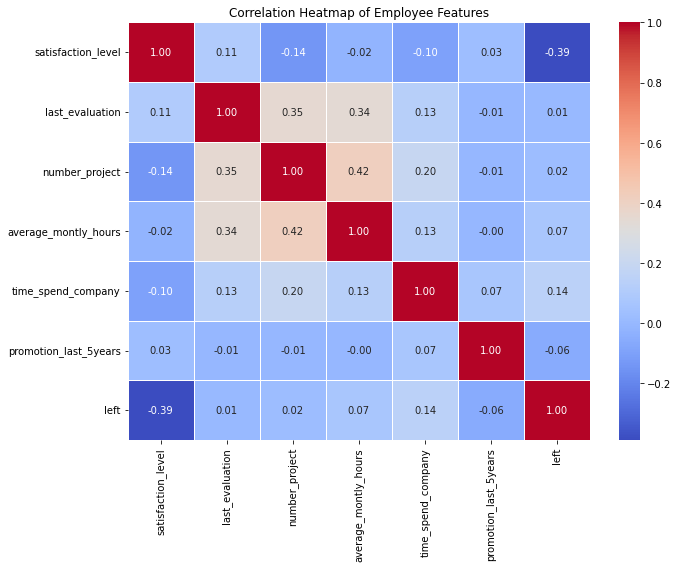

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Employee Features")
plt.tight_layout()
plt.show()

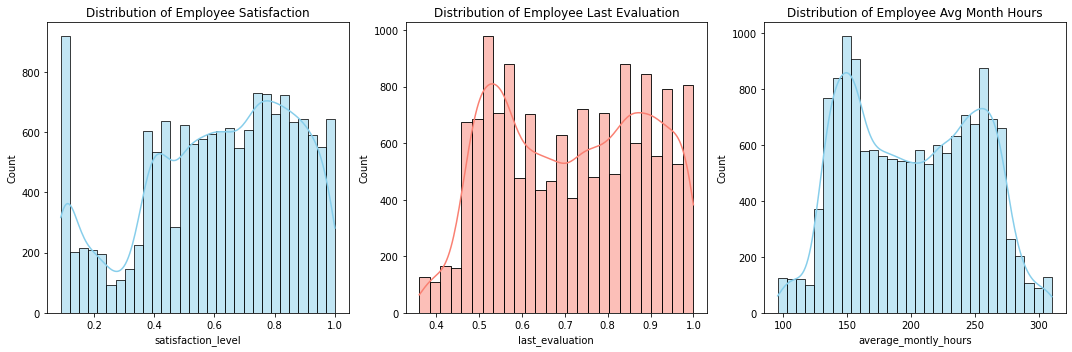

In [9]:
# Distribution plot of: 
# 1. Employee Satisfaction (use column `satisfaction_level`)
# 2. Employee Evaluation (use column `last_evaluation`)
# 3. Employee Average Monthly Hours (use column `average_montly_hours`)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.histplot(data=hr_data, x='satisfaction_level', kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Employee Satisfaction')

sns.histplot(data=hr_data, x='last_evaluation', kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Employee Last Evaluation')

sns.histplot(data=hr_data, x='average_montly_hours', kde=True, ax=axes[2], color='skyblue')
axes[2].set_title('Distribution of Employee Avg Month Hours')

plt.tight_layout()
plt.show()

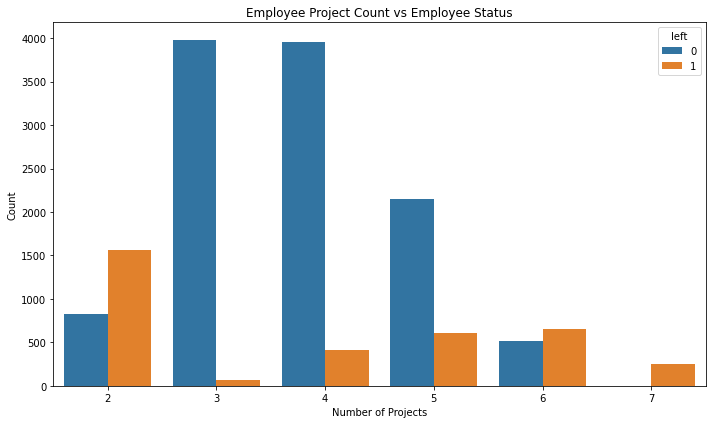

In [10]:
# Bar plot of the employee project count of both employees who left and stayed in the organization 

left_counts = hr_data.loc[hr_data['left'] == 1, 'number_project'].value_counts()
stayed_counts = hr_data.loc[hr_data['left'] == 0, 'number_project'].value_counts()

plt.figure(figsize=(10,6))
sns.countplot(x='number_project', hue='left', data=hr_data)
plt.title('Employee Project Count vs Employee Status')
plt.xlabel('Number of Projects')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Inferences
The previous chart shows how many projects people at work are doing, and whether they stayed at the company or left.
* Most people are working on 3 or 4 projects. These people usually stay at the company.
* Some people only have 2 projects, and a few of them left the company.
* Very few people are doing 6 or 7 projects. That’s a lot, and not many people are doing that much.

### In short:
* The sweet spot for project assignments might be around 3–4 projects, which could be optimal for retention.
* If employees with very low or very high project counts are more likely to leave, this could indicate issues like underutilization or burnout.

/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


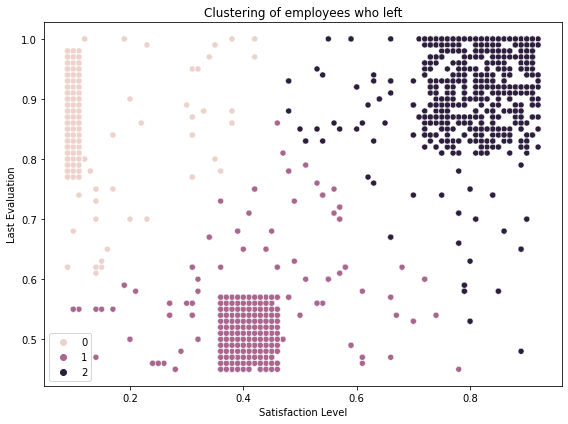

In [11]:
# Clustering of employees who left based on their satisfaction and evaluation.

kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(hr_data.loc[hr_data['left'] == 1, ['satisfaction_level','last_evaluation']])
labels = kmeans.labels_

plt.figure(figsize=(8,6))
sns.scatterplot(x='satisfaction_level', y='last_evaluation', hue=labels, data=hr_data.loc[hr_data['left'] == 1])
plt.title('Clustering of employees who left')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.tight_layout()
plt.show()

## Inferences
The 3 groups (clusters): 
1. Low Satisfaction, High Evaluation (light pink): These people were doing well at work (high scores) but were not happy. They might have felt overworked, unappreciated, or burned out.
2. Medium Satisfaction, Medium Evaluation (purple): These employees were kind of in the middle—not too happy, not too unhappy. They might have left because they didn’t see growth or motivation.
3. High Satisfaction, High Evaluation (dark purple): These people were happy and doing great, but still left. Maybe they got better offers, wanted new challenges, or had personal reasons.

         number_project  average_montly_hours  time_spend_company  \
cluster                                                             
0              6.116525            271.978814            4.079449   
1              2.176970            150.091515            3.069697   
2              4.505629            241.857728            5.042989   

         Work_accident  promotion_last_5years  
cluster                                        
0             0.048729               0.003178  
1             0.046061               0.007273  
2             0.048106               0.004094  


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


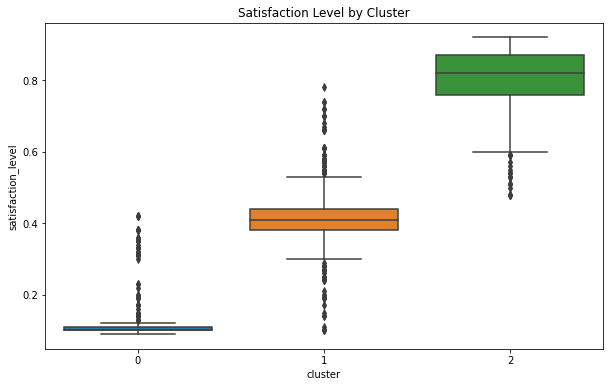

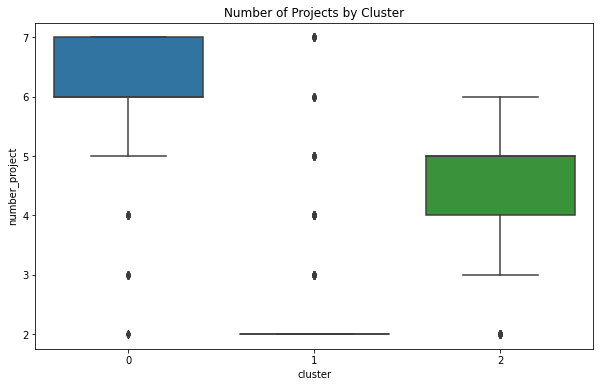

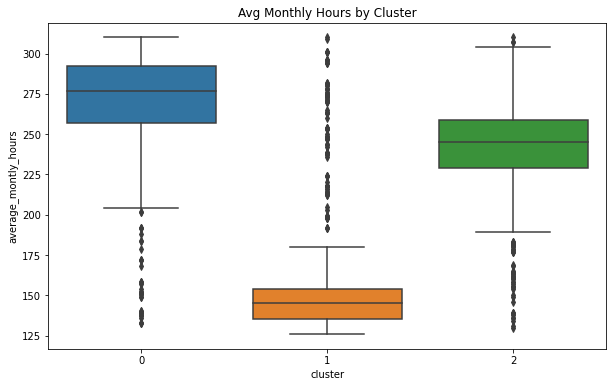

In [12]:
# Additional graphs
# Creating an additional column with the cluster ID from previous step
left_employees = hr_data[hr_data['left'] == 1].copy()
kmeans = KMeans(n_clusters=3, random_state=123)
left_employees['cluster'] = kmeans.fit_predict(left_employees[['satisfaction_level', 'last_evaluation']])

# Compare average values of other features across the 3 clusters
cluster_summary = left_employees.groupby('cluster')[['number_project', 'average_montly_hours', 'time_spend_company','Work_accident', 'promotion_last_5years']].mean()
print(cluster_summary)

# Satisfaction vs Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='satisfaction_level', data=left_employees)
plt.title('Satisfaction Level by Cluster')
plt.show()

# Number of Projects vs Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='number_project', data=left_employees)
plt.title('Number of Projects by Cluster')
plt.show()

# Avg Monthly Hours vs Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='average_montly_hours', data=left_employees)
plt.title('Avg Monthly Hours by Cluster')
plt.show()

# Inferences
1. Low Satisfaction, High Evaluation (light pink): Likely burnout. High workload (Most projects and longest hours). 4+ years on the company. Interpretation: These employees may have left due to overwork and lack of recognition.
2. Medium Satisfaction, Medium Evaluation (purple): Possibly disengaged or underutilized. Fewest projects and hours. Lowest tenure. These employees might have felt bored, unchallenged, or disconnected.
3. High Satisfaction, High Evaluation (dark purple): Possibly stable but stagnant. Moderate workload, longest tenure. These employees may have left due to lack of growth or career progression.

In [13]:
# Clean up and prepare the data
# We want to turn words (like 'department' and 'salary') into numbers so the computer can understand them.

# These are the columns with words (categories)
categorical_cols = ['department', 'salary']

# These are the columns with numbers already
numeric_cols = [
    'satisfaction_level', 'last_evaluation', 'number_project',
    'average_montly_hours', 'time_spend_company',
    'promotion_last_5years', 'Work_accident'
]

# Turn the words into numbers using one-hot encoding
hr_data = pd.get_dummies(hr_data, columns=categorical_cols)

# Separate the features (X) from the target (y)
X = hr_data.drop('left', axis=1)  # Everything except 'left'
y = hr_data['left']               # This is what we want to predict

# Split the data into training and testing sets
# We keep 80% for training and 20% for testing, and make sure both sets have the same mix of people who left and stayed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Use SMOTE to balance the training data
# SMOTE makes more examples of the "left = 1" group so the model learns fairly
smote = SMOTE(random_state=123)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Let's see how many people we have now in each group
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: 0    9142
1    2857
Name: left, dtype: int64
After SMOTE: 0    9142
1    9142
Name: left, dtype: int64


In [14]:
# Train and test 3 different models using 5-fold cross-validation: Logistic Regression, Random Forest and Gradient Boosting
# This means we split the training data into 5 parts and test each model 5 times to see how well it does
models = {
    'Logistic Regression': LogisticRegression(random_state=123, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=123),
    'Gradient Boosting': GradientBoostingClassifier(random_state=123)
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Try each model one by one
for name, model in models.items():
    scores = []
    print(f"\nModel: {name}")
    
    # Do 5 rounds of training and testing
    for fold, (train_index, val_index) in enumerate(kf.split(X_train_res, y_train_res), 1):
        X_fold_train = X_train_res.iloc[train_index]
        X_fold_val = X_train_res.iloc[val_index]
        y_fold_train = y_train_res.iloc[train_index]
        y_fold_val = y_train_res.iloc[val_index]
        
        # Train the model
        model.fit(X_fold_train, y_fold_train)
        
        # Make predictions
        y_pred = model.predict(X_fold_val)
        
        # Measure how well it did
        acc = accuracy_score(y_fold_val, y_pred)
        scores.append(acc)
        
        # Print a detailed report
        print(f"  Fold {fold} Accuracy: {acc:.3f}")
        print(classification_report(y_fold_val, y_pred, zero_division=0))
    
    # Show the average accuracy after all 5 folds
    print(f"Average Accuracy: {np.mean(scores):.3f}")


Model: Logistic Regression
  Fold 1 Accuracy: 0.818
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1829
           1       0.82      0.82      0.82      1828

    accuracy                           0.82      3657
   macro avg       0.82      0.82      0.82      3657
weighted avg       0.82      0.82      0.82      3657

  Fold 2 Accuracy: 0.805
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1829
           1       0.79      0.82      0.81      1828

    accuracy                           0.81      3657
   macro avg       0.81      0.81      0.81      3657
weighted avg       0.81      0.81      0.81      3657

  Fold 3 Accuracy: 0.814
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1828
           1       0.80      0.84      0.82      1829

    accuracy                           0.81      3657
   macro avg       0.81  

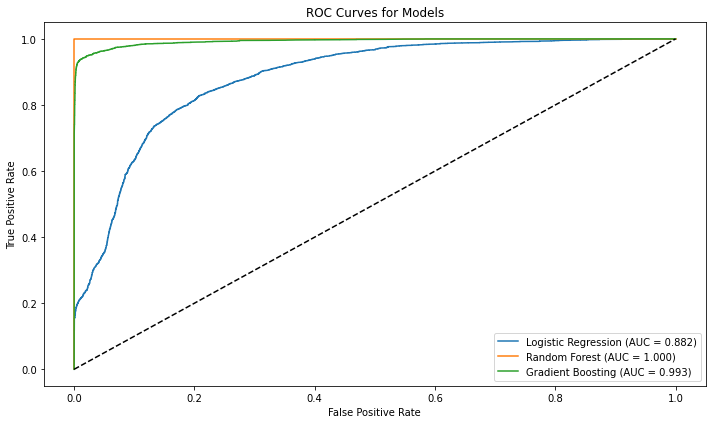

In [15]:
# Compare the models using ROC curves
# ROC curves help us see how good each model is at telling apart people who will leave vs. stay

plt.figure(figsize=(10, 6))
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred_proba = model.predict_proba(X_train_res)[:, 1]
    fpr, tpr, _ = roc_curve(y_train_res, y_pred_proba)
    auc = roc_auc_score(y_train_res, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line = random guessing
plt.title('ROC Curves for Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

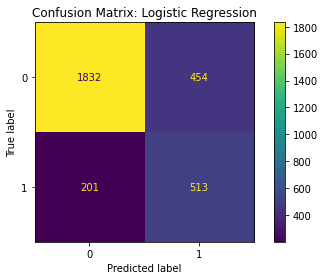

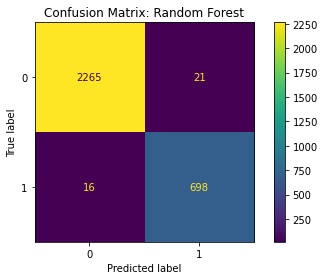

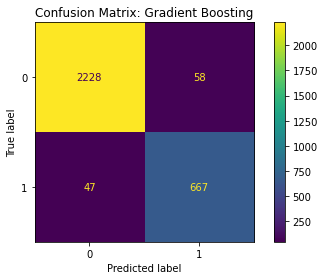

In [16]:
# Show confusion matrices for each model
# This tells us how many people the model got right or wrong

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix: {name}')
    plt.tight_layout()
    plt.show()

# Inferences
## What the ROC Curve Shows:
* X-axis: False Positive Rate (how often the model is wrong when it says someone will leave)
* Y-axis: True Positive Rate (how often the model is right when it says someone will leave)
* The closer the curve is to the top-left corner, the better the model.
## AUC Scores (Area Under the Curve):
* Random Forest: AUC = 1.000 → Perfect performance (possibly overfitting)
* Gradient Boosting: AUC = 0.994 → Excellent performance
* Logistic Regression: AUC = 0.882 → Very good, but not as strong as the others
## Overall
* All three models perform well, but Random Forest and Gradient Boosting are clearly stronger.
* Random Forest might be overfitting (too perfect on training data), we should check its performance on the test set too.
* Gradient Boosting is a strong and often more generalizable model.

## Recall or Precision?
* If your goal is to catch as many people who might leave as possible, then Recall is more important: "Of all the people who actually left, how many did we catch?"
* If your goal is to avoid wrongly flagging people as at risk, then Precision is more important: "Of all the people we said would leave, how many actually did?"
* In HR analytics, Recall is usually more important — you want to catch at-risk employees early, even if you get a few wrong.

In [17]:
# Use the best model (Gradient Boosting here) to predict risk zones
# We'll look at the last 100 employees and see how likely they are to leave

log_reg = models['Gradient Boosting']
y_pred_proba_test = log_reg.predict_proba(X_test.iloc[-100:])[:, 1]

zones = []
for prob in y_pred_proba_test:
    if prob < 0.2:
        zones.append('Safe Zone (Green)')
    elif prob < 0.6:
        zones.append('Low-Risk Zone (Yellow)')
    elif prob < 0.9:
        zones.append('Medium-Risk Zone (Orange)')
    else:
        zones.append('High-Risk Zone (Red)')

# Combine into a nice table
risk_df = pd.DataFrame({
    'Probability': y_pred_proba_test,
    'Risk Zone': zones
})

print(risk_df.head(10))  # Show the first 10 predictions

   Probability             Risk Zone
0     0.036605     Safe Zone (Green)
1     0.090399     Safe Zone (Green)
2     0.982853  High-Risk Zone (Red)
3     0.911092  High-Risk Zone (Red)
4     0.147759     Safe Zone (Green)
5     0.991166  High-Risk Zone (Red)
6     0.012059     Safe Zone (Green)
7     0.020713     Safe Zone (Green)
8     0.034648     Safe Zone (Green)
9     0.008395     Safe Zone (Green)
